# AnomalyDetection_2_DefiningProblem

**Updates from old notebook:** 
- Data has been filtered (after adding the thresholds)
- The data is quite sparse and has lots of gaps in between, this raises one main problem:
    1. Forecasting methods cannot be used to find anomalies in the data
    2. Is the model robust? Will it work the same for different users or does one require training for each user?
- Recall the purpose of this anomaly detection module:
    1. Detect when the movements are lower "on average" (this is analogous to 'overflow' from the fluid detection module, i.e. a tap that is left open and thus the flow is higher, on average)
    2. Adapt to the fact that the average movements will be decreasing as a function of time (because the person is getting older)
    3. Detect that there is an overall decrease in daily activity (as measured by how 'strong' the activity is, how frequent naps are)
    4. Detect that there is a high lack of motion (i.e. if the person removed their device or is critically ill), and detect the opposite, when there is a high amount of motion that is abnormal (if the device is attached to a dog)
    
Based on this, it is likely that there is no 'one model' to solve all solution. Each of the above problems might require a different model. We just need to be smart about how we model it to a) make the solution simple and thus robust, and b) integrate it with the raspberry such that it does not take up too much memory / computational time.

## Libraries and Configuration

In [28]:
""" Libraries """

#file / system libraries 
import os
import datetime as dt

# mathematical 

from numpy.fft import ifft
from numpy.fft import fft
import numpy as np

# data exploration

import pandas as pd

# data visualization

import matplotlib.pyplot as plt

""" Configuration """

# pandas 

pd.set_option('display.max_columns', None)

## Functions

In [16]:
def polynomial(x):
    """ takes an array and returns it after our polynomial function has been applied to it"""
    C = [0.7741697399557282,-0.15839741967042406,0.09528795099596377,-0.004279871380772796]
    y = C[0]*np.power(x,4)+C[1]*np.power(x,2)+C[2]*x+C[3]
    return y

def directory_to_df(paths, exclude = [None], filetype = '.csv',ignore_index = True, exception = '_repet'):
    """ concatenates all files in a directory into a dataframe
    components:
    path: path to the directory (must end with /)
    exclude: array of directories to excludes from the treatment
    filetype: a string of the file extension (must include .)
    ignore_index: boolean that tells pandas to ignore the index or not
    exception: takes a string. Any time a filename includes this string it is treated differently (for cases when you have
    more than one ) 
    """
    filenames = []
    file_column = []
    frames = []
    test_index = 1
    
    for path in paths:
        for filename in os.listdir(path):
            print(path)
            if filetype in filename and filename not in exclude:
                if exception in filename:
                    curr_df = pd.read_csv(path+filename)
                    curr_df = special_treatment(curr_df)
                    
                else:
                    curr_df = pd.read_csv(path+filename)                    
                frames.append(curr_df)
                filenames.append(filename.replace(filetype,''))
                for i in range(curr_df.shape[0]):
                    file_column.append(test_index)
                test_index+=1

    df = pd.concat(frames,ignore_index = ignore_index)
    df['files'] = file_column
    return df, filenames


def special_treatment(df):
    """ performs a custom operation on a dataframe
    components:
    df: dataframe to play on
    """
    columns = df.columns.values.tolist()
    columns.remove('date')
    df.drop('gyrZ',inplace = True, axis = 1)
    df.columns = columns
    df.reset_index(inplace = True)
    df.rename(columns= {'index':'date'},inplace = True)
    return df

class seasonality():
    """ takes in a dataframe, outputting it with two extra columns: seasonality (but column name = seasonality
    inputted) and times, where 'times' is a plottable version of date with reference to a prespecified start time
    (day_start)
    Components:
    df: the dataframe, must have the dates column as 'date' and in np.datetime64 timeformat
    seasonality (optional): defaults to 'day'. This is the criteria for splitting the data
    day_start (optional): this signifies what is the 'start time' of the day (i.e. the 0 point on the x axis). Defaults
    for midnight.
    time_delta (optional): this defines the units for the time delta between data points. Defaults to seconds.
    EDIT THIS MSG
    NEED TO FIX THIS
    """ 
    def __init__(self,df,seasonality='day',day_start = '00:00:00', time_delta = 's'):
        
        if seasonality not in ['hour','day','month','year']:
            raise ValueError("you can only input the following for seasonality: 'day', 'month', or 'year'")
        self.df = df
        self.seasonality = 'seasonality_{}'.format(seasonality)
        try:
            self.day_start = dt.datetime.strptime(day_start,'%H:%M:%S')
        except:
            raise ValueError('Please enter your day_start in the correct format: "HH:MM:SS". "{}" is not acceptable'\
                             .format(day_start))
        self.time_delta = time_delta

    def find_seasonal_trends(self):
        if 'hour' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.hour
        elif 'day' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.day
        elif 'month' in self.seasonality:
            self.df[self.seasonality] = self.df.date.dt.month
        else:
            self.df[self.seasonality] = self.df.date.dt.year
            
        self.create_times()


        return self.df
    
    def create_times(self):
        times = []
        for season in self.df[self.seasonality].unique():
            temp_dates = self.df.date[self.df[self.seasonality] == season].values
            date = dt.datetime.strptime(str(temp_dates[0])[:-3], '%Y-%m-%dT%H:%M:%S.%f')
            # 'date' is wrong: this will not work for when you have a lower order seasonality.
            # it needs to adapt such that it starts recording when the beginning of the year
            start_day = dt.datetime(date.year,
                                    date.month,
                                    date.day,
                                    self.day_start.hour,
                                    self.day_start.minute,
                                    self.day_start.second)
            start_day = np.datetime64(start_day)
            
            for index, date in enumerate(temp_dates):
                times.append((date - start_day)/np.timedelta64(1, self.time_delta))
        self.df['times'] = times

## Data

In [21]:
base = '/Users/yousefnami/KinKeepers/ProjectAI/Kin-Keepers/Data/{}'
names = ['rohan','ignacio']
end_labels = ['_filtered.csv']
dfs = []

for index,name in enumerate(names):
    dfs.append(pd.read_csv(base.format(names[index]+end_labels[0]),index_col = 0))

In [22]:
dfs[0].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
220,2020-09-14 19:19:26,0.01,0.02,0.00,3.62,1.04,1.38,1,0.022361,4.011284
319,2020-09-14 19:20:39,0.09,0.16,0.14,36.11,25.84,67.85,1,0.230868,81.087978
320,2020-09-14 19:20:40,0.09,0.16,0.09,22.98,15.43,16.45,1,0.204450,32.198879
321,2020-09-14 19:20:41,0.05,0.07,0.09,22.98,15.43,16.45,1,0.124499,32.198879
322,2020-09-14 19:20:42,0.12,0.07,0.07,29.44,39.83,27.27,1,0.155563,56.540210


In [23]:
dfs[1].head()

,date,accX,accY,accZ,gyrX,gyrY,gyrZ,files,accTotal,gyrTotal
0,2020-09-13 17:09:25,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
1,2020-09-13 17:09:26,0.02,0.12,0.03,1.47,3.32,2.22,1,0.125300,4.255784
2,2020-09-13 17:09:27,0.01,0.01,0.00,7.43,6.82,10.10,1,0.014142,14.273307
12,2020-09-13 17:09:34,0.01,0.01,0.00,6.64,7.07,12.45,1,0.014142,15.782173
13,2020-09-13 17:09:34,0.01,0.01,0.00,4.12,3.61,5.81,1,0.014142,7.985149


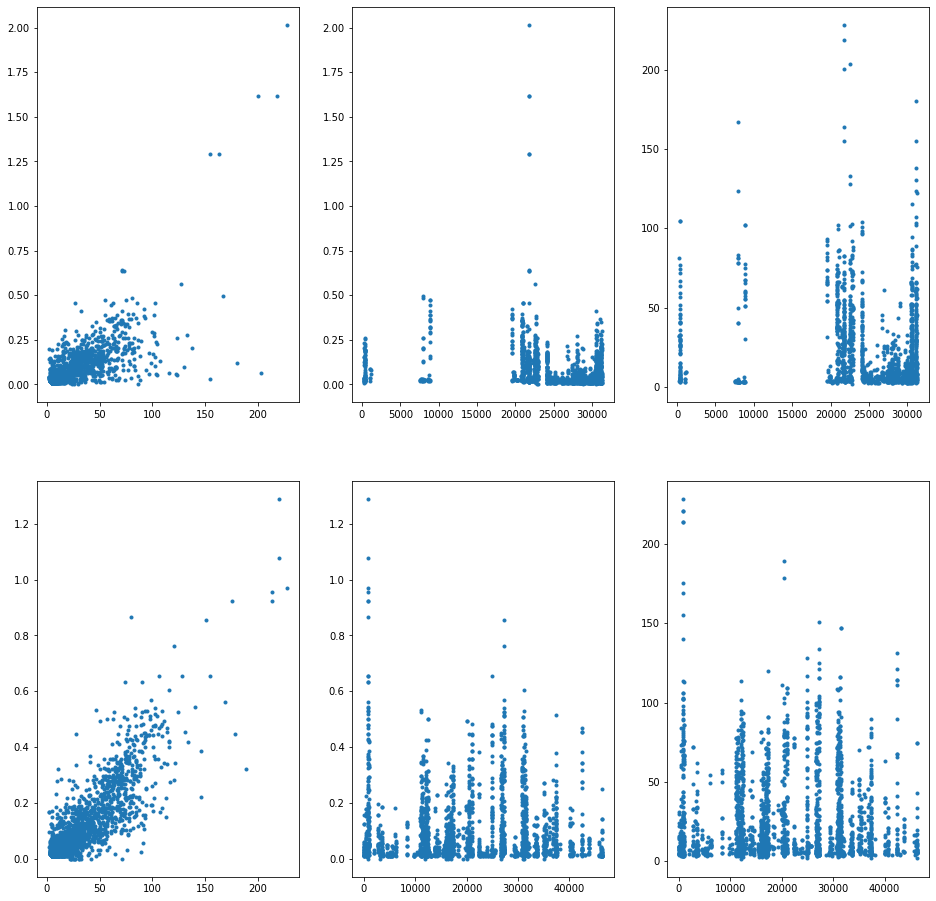

In [25]:
fig = plt.figure(figsize = (16,16))
i = 1
for df in dfs:
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.gyrTotal,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.accTotal,'.')
    i+=1
    
    fig.add_subplot(len(dfs),3,i)
    plt.plot(df.index,df.gyrTotal,'.')
    i+=1


/Users/yousefnami/python_environments/KinKeepers_AI/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


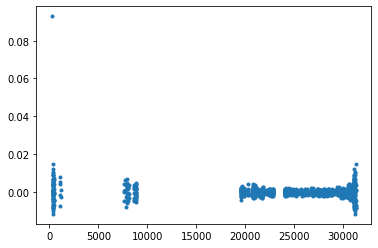

In [61]:
x = dfs[0].index
Y = dfs[0].accTotal

y = ifft(Y)
plt.plot(x,y,'.')

# fourier seems to give us a 'nicer' curve but no information as to what is represents. Perhaps it's worth exploring
# this with the test data (i.e. the specific movements)

## 1. Detecting when movements are smaller 'on average'

Definition:
Movements are defined on 

## 2. Adapt to the fact that the seniors movements will be decreasing, on average, as a function of time

Definition:


Ideas:
- can you use Fluid Mechanics (Turbulence) ideas? On how statistically stationary your movements are? Do you need more data on this?

## 3. Detecting if there is an 'overall' decrease in daily activity (as measured totally by how mant naps there are, how strong the movements are)

Definition:
Movements are defined on 

Ideas:
- can you convert gyration and acceleration into an 'energy' parameter and count it?

## 4. Detecting if there are large 'gaps' in data (i.e. long naps) or if there are spikes in continuous large movements

Definition:
Movements are defined on 